In [1]:
from pathlib import Path
import sys
import json
from argparse import ArgumentParser, Namespace

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

sys.path.append('..')

from src.models import LandCoverMapper, STR2MODEL
from src.utils.visualize import plot_roc_curve

## Experimenting

In [29]:
model_path = '../data/lightning_logs/version_896/checkpoints/epoch=21.ckpt' # obtained with python models.py --geowiki_subset neighbours1 --weighted_loss_fn --inference True
#model_path = '../data/lightning_logs/version_899/checkpoints/epoch=21.ckpt' -> from results/final. Those in paper
#model_path = '../data/lightning_logs/version_919/checkpoints/epoch=21.ckpt'
model = LandCoverMapper.load_from_checkpoint(model_path, data_folder='../data')

Found normalizing dict geowiki_normalizing_dict_Ghana_Togo_Nigeria_Cameroon_Benin.h5
Loading normalizing dict geowiki_normalizing_dict_Ghana_Togo_Nigeria_Cameroon_Benin.h5
Creating Geowiki train split
Creating Geowiki val split
Number of instances in Geowiki training set: 632
Number of instances in Nigeria training set: 913
Total number of files used for training: 1545
Number of instances in Geowiki validation set: 158
Number of instances in Nigeria validation set: 454
Total number of files used for validation: 612
Number of global labels: 2157
Number of local labels: 0
Global class weights: tensor([1.9004, 2.1106])
Local class weights: None
Number of model parameters: 25473


In [3]:
# logger = TensorBoardLogger('dummy_logs', name='dummy_model') # dummy logger just so that when validation_step is called, it doesn't complain about not having a logger
# model.logger = logger

In [31]:
model.training

True

In [32]:
if model.training:
    model.eval() # important for deactivating dropout
model.training

False

In [33]:
model.save_validation_predictions()

Number of instances in Nigeria testing set: 455


In [34]:
split = 'testing'
preds_path = Path(f'../data/LandCoverMapper/{split}/all_preds.npy')
labels_path = Path(f'../data/LandCoverMapper/{split}/all_labels.npy')
# preds_path = Path(model_path).parent.parent / split / 'all_preds.npy'
# labels_path = Path(model_path).parent.parent / split / 'all_labels.npy'

In [35]:
preds = np.load(preds_path).squeeze()
labels = np.load(labels_path).squeeze()

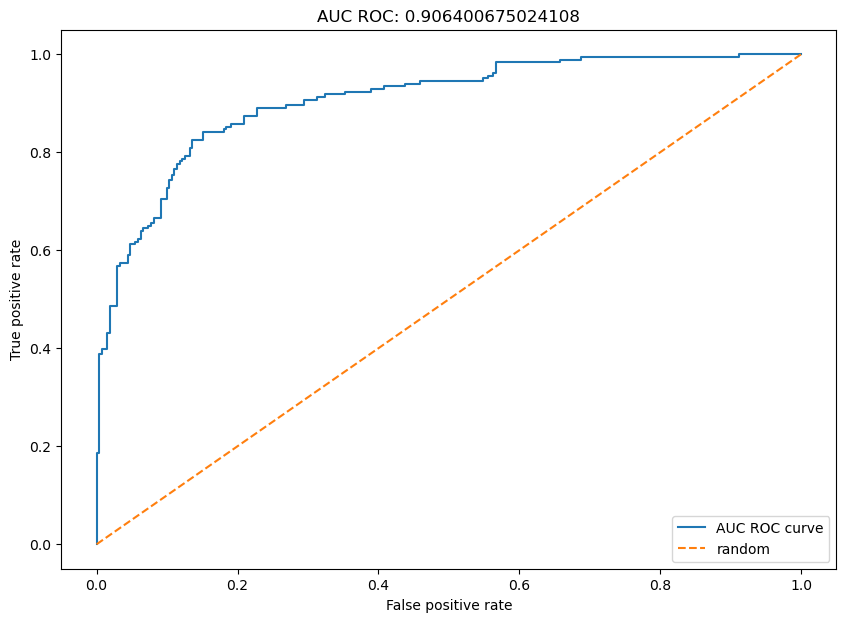

In [36]:
plot_roc_curve(labels, preds, threshold_spacing=None)

In [37]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [38]:
roc_auc_score(labels, preds)

0.906400675024108

In [39]:
fpr, tpr, thresholds = roc_curve(labels, preds)
auc(fpr, tpr)

0.906400675024108

In [40]:
preds = (preds > 0.5).astype(int)
print(precision_score(labels, preds))
print(recall_score(labels, preds))
print(f1_score(labels, preds))
print(accuracy_score(labels, preds))

0.7875647668393783
0.8306010928961749
0.8085106382978724
0.8417582417582418


: 

## Plot several curves

In [2]:
results_dir = 'final2' # included saving preds arrays on test set
model_base = 'lstm'
results_path = Path('../results') / results_dir / model_base / f'results_{results_dir}_{model_base}.csv'
df = pd.read_csv(results_path)
df

,add_nigeria,add_geowiki,geowiki_subset,multi_headed,weighted_loss_fn,hidden_vector_size,final_epoch,num_rnn_layers,test_on,log_dir,...,test_precision_score,test_recall_score,test_f1_score,test_accuracy,test_TN,test_FP,test_FN,test_TP,result_filepath,result_timestamp
0,True,False,world,False,True,64,30,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.771739,0.775956,0.773842,0.817582,230.0,42.0,41.0,142.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_211436
1,True,True,nigeria,False,True,64,28,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.770732,0.863388,0.814433,0.841758,225.0,47.0,25.0,158.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_211918
2,True,True,neighbours1,False,True,64,25,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.787565,0.830601,0.808511,0.841758,231.0,41.0,31.0,152.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_212226
3,True,True,world,False,True,64,30,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.670996,0.846995,0.748792,0.771429,196.0,76.0,28.0,155.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_220707
4,False,True,nigeria,False,True,64,37,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.561475,0.748634,0.641686,0.663736,165.0,107.0,46.0,137.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_221032
5,False,True,neighbours1,False,True,64,26,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.687783,0.830601,0.752475,0.780220,203.0,69.0,31.0,152.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_221605
6,False,True,world,False,True,64,25,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.574913,0.901639,0.702128,0.692308,150.0,122.0,18.0,165.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_230843
7,True,True,neighbours1,True,True,64,23,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.737327,0.874317,0.800000,0.824176,215.0,57.0,23.0,160.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230806_231325
8,False,True,world,True,True,64,34,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.721212,0.650273,0.683908,0.758242,226.0,46.0,64.0,119.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230807_000858
9,True,True,world,True,True,64,29,1,testing,/mnt/Data/jgajardo/code/togo-crop-mask/scripts...,...,0.916667,0.540984,0.680412,0.795604,263.0,9.0,84.0,99.0,/mnt/Data/jgajardo/code/togo-crop-mask/results...,20230807_005805


In [3]:
# Grab two best configs per model type
labels = []
preds = []
names = []
log_names = []

for flag in (False, True):
    group = 'Multi-headed LSTM' if flag else 'Single-headed LSTM'
    prefix = 'Nigeria' if flag else 'all'
    df_subset = df[df['multi_headed'] == flag].sort_values(by='test_accuracy', ascending=False).head(2).reset_index(drop=True)
    
    for i in range(len(df_subset)):
        log_dir_path = Path(df_subset.log_dir[i])
        preds_path = log_dir_path / 'testing' / f'{prefix}_preds.npy'
        labels_path = log_dir_path / 'testing' / f'{prefix}_labels.npy'
        preds.append(np.load(preds_path).squeeze())
        labels.append(np.load(labels_path).squeeze())
        names.append(f'{group} (Geowiki {df_subset.geowiki_subset[i]})')
        log_names.append(log_dir_path.name) 

names = [name.replace('neighbours1', 'neighbours') for name in names]
names = [name.replace('nigeria', 'Nigeria') for name in names]
names, log_names

(['Single-headed LSTM (Geowiki Nigeria)',
  'Single-headed LSTM (Geowiki neighbours)',
  'Multi-headed LSTM (Geowiki neighbours)',
  'Multi-headed LSTM (Geowiki world)'],
 ['version_923', 'version_924', 'version_929', 'version_931'])

In [4]:
# Helper functions
def get_metrics(y_true, y_probs):
    roc_auc = roc_auc_score(y_true, y_probs)
    y_pred = (y_probs > 0.5).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    print('RF roc-auc test set:', round(roc_auc, 3))
    print('RF precision test set:', round(precision, 3))
    print('RF recall test set:', round(recall, 3))
    print('RF f1-score test set:', round(f1, 3))
    print('RF accuracy test set:', round(acc, 3))

    return {'roc_auc': roc_auc, 'precision': precision, 'recall': recall, 'f1': f1, 'acc': acc}

def get_model(add_geowiki: bool, add_nigeria: bool, geowiki_subset: str):
    parser = ArgumentParser()
    parser.add_argument("--max_epochs", type=int, default=100)
    parser.add_argument("--patience", type=int, default=10)
    parser.add_argument("--gpus", type=int, default=0)
    parser.add_argument("--wandb", default=False, action="store_true")

    model_args = STR2MODEL["land_cover"].add_model_specific_args(parser).parse_args(args=[])
    new_model_args_dict = vars(model_args)

    # SET MODIFICATIONS TO DEFAULT MODEL ARGUMENTS:
    new_model_args_dict['add_geowiki'] = add_geowiki
    new_model_args_dict['add_nigeria'] = add_nigeria
    new_model_args_dict['geowiki_subset'] =  geowiki_subset # 'nigeria', 'neighbours1'

    new_model_args = Namespace(**new_model_args_dict)
    model = STR2MODEL["land_cover"](new_model_args)
    
    return model

def get_dataset_splits(add_geowiki: bool, add_nigeria: bool, geowiki_subset: str='world', S2_features_only: bool=False):

    # Dirty hack, we use landcovermapper class (only supporting lstm model) class to access model splits
    lancovermapper = get_model(add_geowiki, add_nigeria, geowiki_subset)

    train_dataset = lancovermapper.get_dataset(subset="training").as_array(flatten_x=True, S2_features_only=S2_features_only)
    val_dataset = lancovermapper.get_dataset(subset="validation", normalizing_dict=lancovermapper.normalizing_dict).as_array(flatten_x=True, S2_features_only=S2_features_only)
    #test_dataset = lancovermapper.get_dataset(subset="validation", normalizing_dict=lancovermapper.normalizing_dict, evaluating=True).as_array(flatten_x=True, S2_features_only=S2_features_only) 
    test_dataset = lancovermapper.get_dataset(subset="testing", normalizing_dict=lancovermapper.normalizing_dict).as_array(flatten_x=True, S2_features_only=S2_features_only)

    return (
        train_dataset,
        val_dataset,
        test_dataset
    )

In [5]:
# Get random forest predictions
add_geowiki = True
add_nigeria = True
geowiki_subset = 'nigeria'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_splits(add_geowiki, add_nigeria, geowiki_subset=geowiki_subset)
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_preds = rf.predict_proba(X_test)[:, 1] # for roc_auc_score
metrics = get_metrics(y_test, y_preds)

labels.append(y_test)
preds.append(y_preds)
names.append('Random Forest (Geowiki Nigeria)')

Found normalizing dict geowiki_normalizing_dict_Nigeria.h5
Loading normalizing dict geowiki_normalizing_dict_Nigeria.h5
Creating Geowiki train split
Creating Geowiki val split
Number of instances in Geowiki training set: 361
Number of instances in Nigeria training set: 913
Total number of files used for training: 1274
Number of model parameters: 25473
Number of instances in Geowiki training set: 361
Number of instances in Nigeria training set: 913
Total number of files used for training: 1274
Number of instances in Geowiki validation set: 91
Number of instances in Nigeria validation set: 454
Total number of files used for validation: 545
Number of instances in Nigeria testing set: 455
RF roc-auc test set: 0.915
RF precision test set: 0.782
RF recall test set: 0.825
RF f1-score test set: 0.803
RF accuracy test set: 0.837


In [6]:
# Get random forest predictions
add_geowiki = True
add_nigeria = True
geowiki_subset = 'neighbours1'
(X_train, y_train), (X_val, y_val), (X_test, y_test) = get_dataset_splits(add_geowiki, add_nigeria, geowiki_subset=geowiki_subset)
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_preds = rf.predict_proba(X_test)[:, 1] # for roc_auc_score
metrics = get_metrics(y_test, y_preds)

labels.append(y_test)
preds.append(y_preds)
names.append('Random Forest (Geowiki neighbours)')

Found normalizing dict geowiki_normalizing_dict_Ghana_Togo_Nigeria_Cameroon_Benin.h5
Loading normalizing dict geowiki_normalizing_dict_Ghana_Togo_Nigeria_Cameroon_Benin.h5
Creating Geowiki train split
Creating Geowiki val split
Number of instances in Geowiki training set: 632
Number of instances in Nigeria training set: 913
Total number of files used for training: 1545
Number of model parameters: 25473
Number of instances in Geowiki training set: 632
Number of instances in Nigeria training set: 913
Total number of files used for training: 1545
Number of instances in Geowiki validation set: 158
Number of instances in Nigeria validation set: 454
Total number of files used for validation: 612
Number of instances in Nigeria testing set: 455
RF roc-auc test set: 0.916
RF precision test set: 0.791
RF recall test set: 0.765
RF f1-score test set: 0.778
RF accuracy test set: 0.824


In [7]:
names

['Single-headed LSTM (Geowiki Nigeria)',
 'Single-headed LSTM (Geowiki neighbours)',
 'Multi-headed LSTM (Geowiki neighbours)',
 'Multi-headed LSTM (Geowiki world)',
 'Random Forest (Geowiki Nigeria)',
 'Random Forest (Geowiki neighbours)']

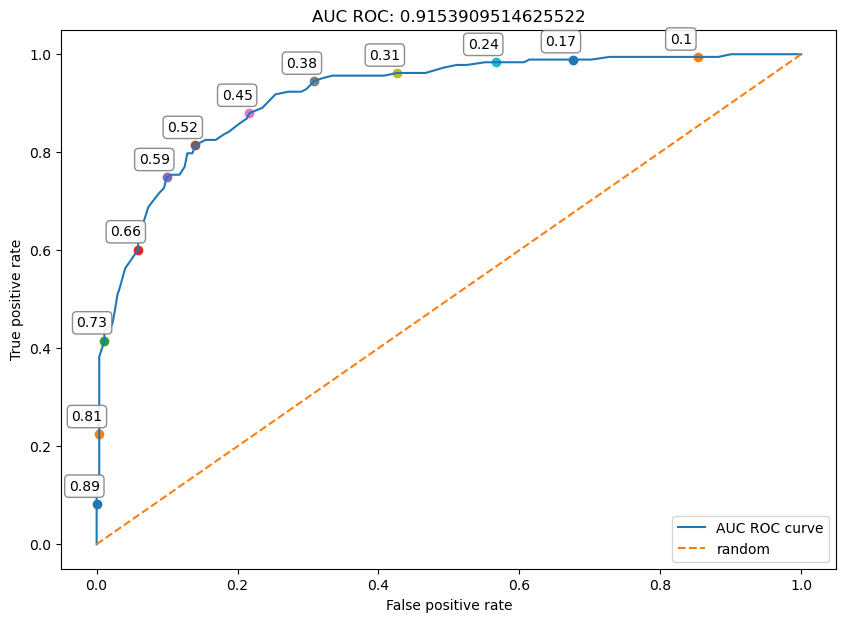

In [8]:
# See thresholds of one model
plot_roc_curve(labels[-2], preds[-2], threshold_spacing=7)

Plot curves of all models

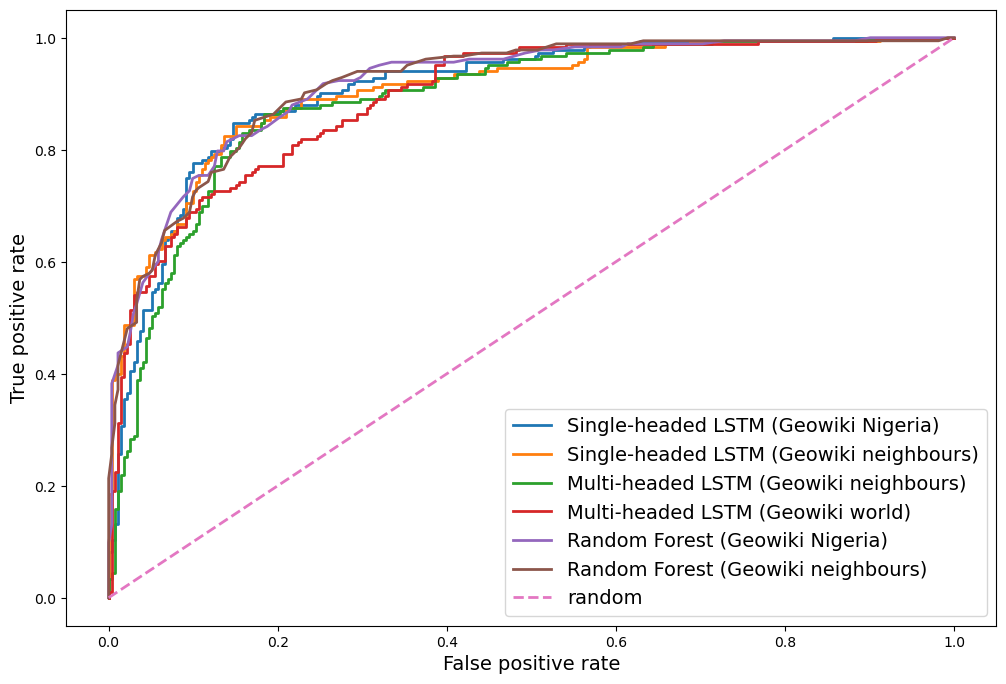

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

for labels_, preds_, name in zip(labels, preds, names):
    fpr, tpr, thresholds = roc_curve(labels_, preds_)
    ax.plot(fpr, tpr, label=name, linewidth=2)

ax.plot([0, 1], [0, 1], linestyle="--", label="random", linewidth=2)
ax.set_xlabel("False positive rate", fontsize=14)
ax.set_ylabel("True positive rate", fontsize=14)
ax.legend(loc="lower right", fontsize=14)
#fig.savefig('../figures/roc-curve-models_fontsize14.png', bbox_inches='tight', dpi=600)
#fig.savefig('../figures/roc-curve-models_fontsize14.pdf', bbox_inches='tight', dpi=600)
plt.show()

Improved figure (color-blinded-friendly pallete)

IndexError: list index out of range

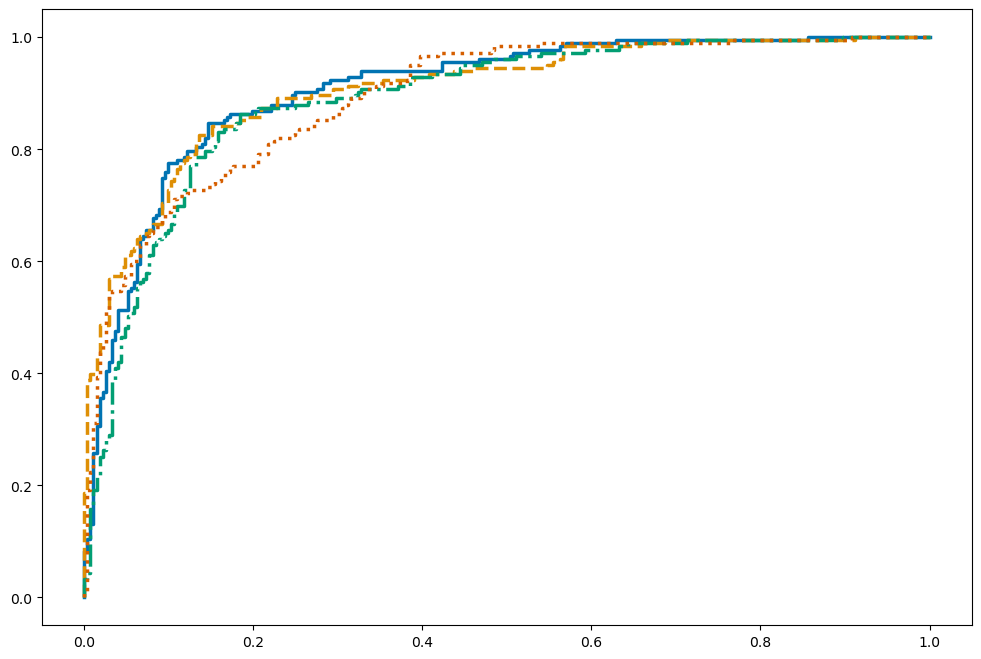

In [10]:
# Set a colorblind-friendly palette
colors = sns.color_palette('colorblind')

fig, ax = plt.subplots(figsize=(12, 8))

# Different line styles for better differentiation
line_styles = ['-', '--', '-.', ':']

for i, (labels_, preds_, name) in enumerate(zip(labels, preds, names)):
    fpr, tpr, thresholds = roc_curve(labels_, preds_)
    ax.plot(fpr, tpr, 
            label=name, 
            linewidth=2.5,
            color=colors[i],
            linestyle=line_styles[i])

# Reference line
ax.plot([0, 1], [0, 1], 
        linestyle=":", 
        label="random", 
        linewidth=2, 
        color='gray')

ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.legend(loc="lower right", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Add title that mentions ROC explicitly
ax.set_title("ROC Curves for Model Comparison", fontsize=16)

# Maintain aspect ratio for better visualization of the curve
ax.set_aspect('equal')

# Tight layout to prevent cutting off of labels
plt.tight_layout()

#fig.savefig('../figures/roc-curve-models_fontsize14.png', bbox_inches='tight', dpi=600)
#fig.savefig('../figures/roc-curve-models_fontsize14.pdf', bbox_inches='tight', dpi=600)
plt.show()

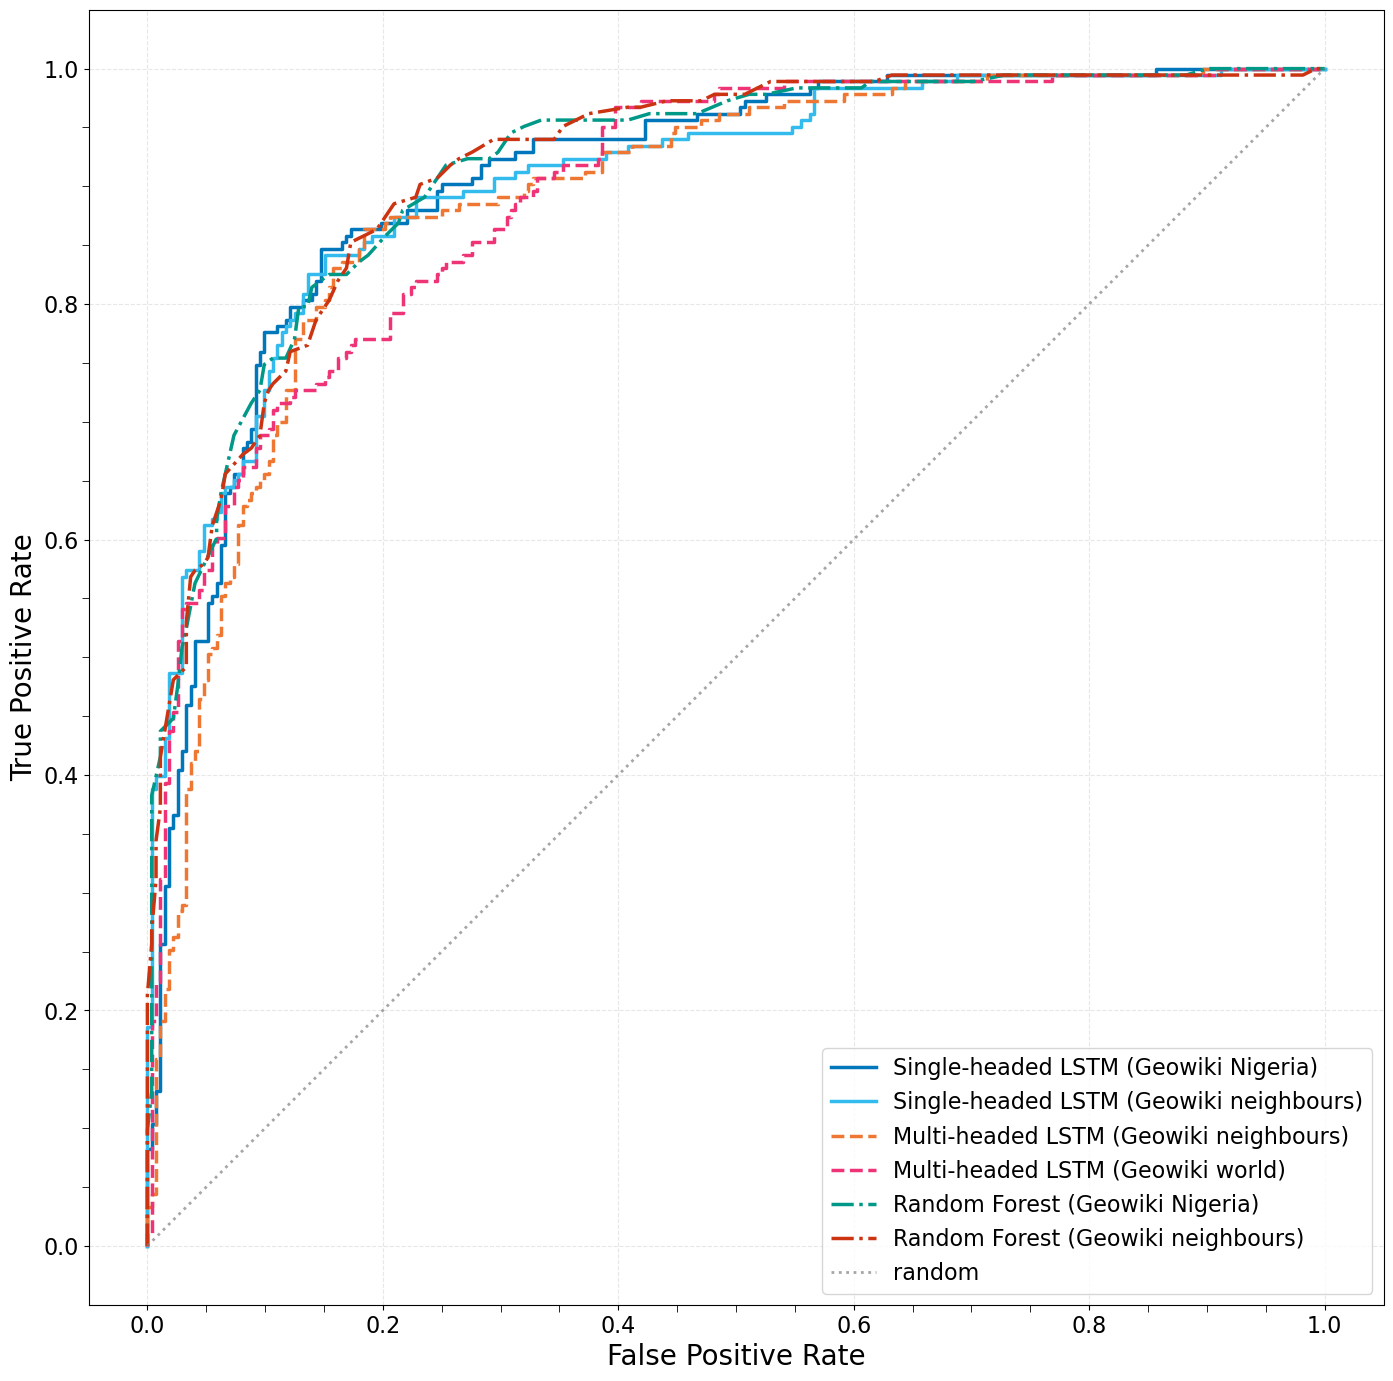

In [15]:
# Set up a specific colorblind-friendly palette
# Using a curated set of colorblind-friendly colors
colors = ['#0077BB',  # Blue
          '#33BBEE',  # Cyan
          '#EE7733',  # Orange
          '#EE3377',  # Magenta
          '#009988',  # Teal
          '#CC3311']  # Red

# Different line styles for each type of model
line_styles = {
    'Single-headed LSTM': '-',      # solid
    'Multi-headed LSTM': '--',      # dashed
    'Random Forest': '-.'           # dash-dot
}

fig, ax = plt.subplots(figsize=(14, 14))

# Plot each model's ROC curve
for i, (labels_, preds_, name) in enumerate(zip(labels, preds, names)):
    # Determine line style based on model type
    for model_type in line_styles.keys():
        if model_type in name:
            style = line_styles[model_type]
            break
            
    fpr, tpr, thresholds = roc_curve(labels_, preds_)
    ax.plot(fpr, tpr, 
            label=name, 
            linewidth=2.5,
            color=colors[i],
            linestyle=style)

# Reference line
ax.plot([0, 1], [0, 1], 
        linestyle=':', 
        label='random', 
        linewidth=2, 
        color='gray',
        alpha=0.7)

ax.set_xlabel("False Positive Rate", fontsize=20)
ax.set_ylabel("True Positive Rate", fontsize=20)
ax.tick_params(labelsize=16)
ax.minorticks_on()
ax.tick_params(size=5, which='minor')
ax.legend(loc="lower right", fontsize=16, bbox_to_anchor=(1.0, 0.0))
ax.grid(True, linestyle='--', alpha=0.3)

# Maintain aspect ratio for better visualization of the curve
ax.set_aspect('equal')

# Tight layout to prevent cutting off of labels
plt.tight_layout()

#fig.savefig('../figures/roc-curve-models_fontsize14.png', bbox_inches='tight', dpi=600)
#fig.savefig('../figures/roc-curve-models_fontsize14.pdf', bbox_inches='tight', dpi=600)
plt.show()

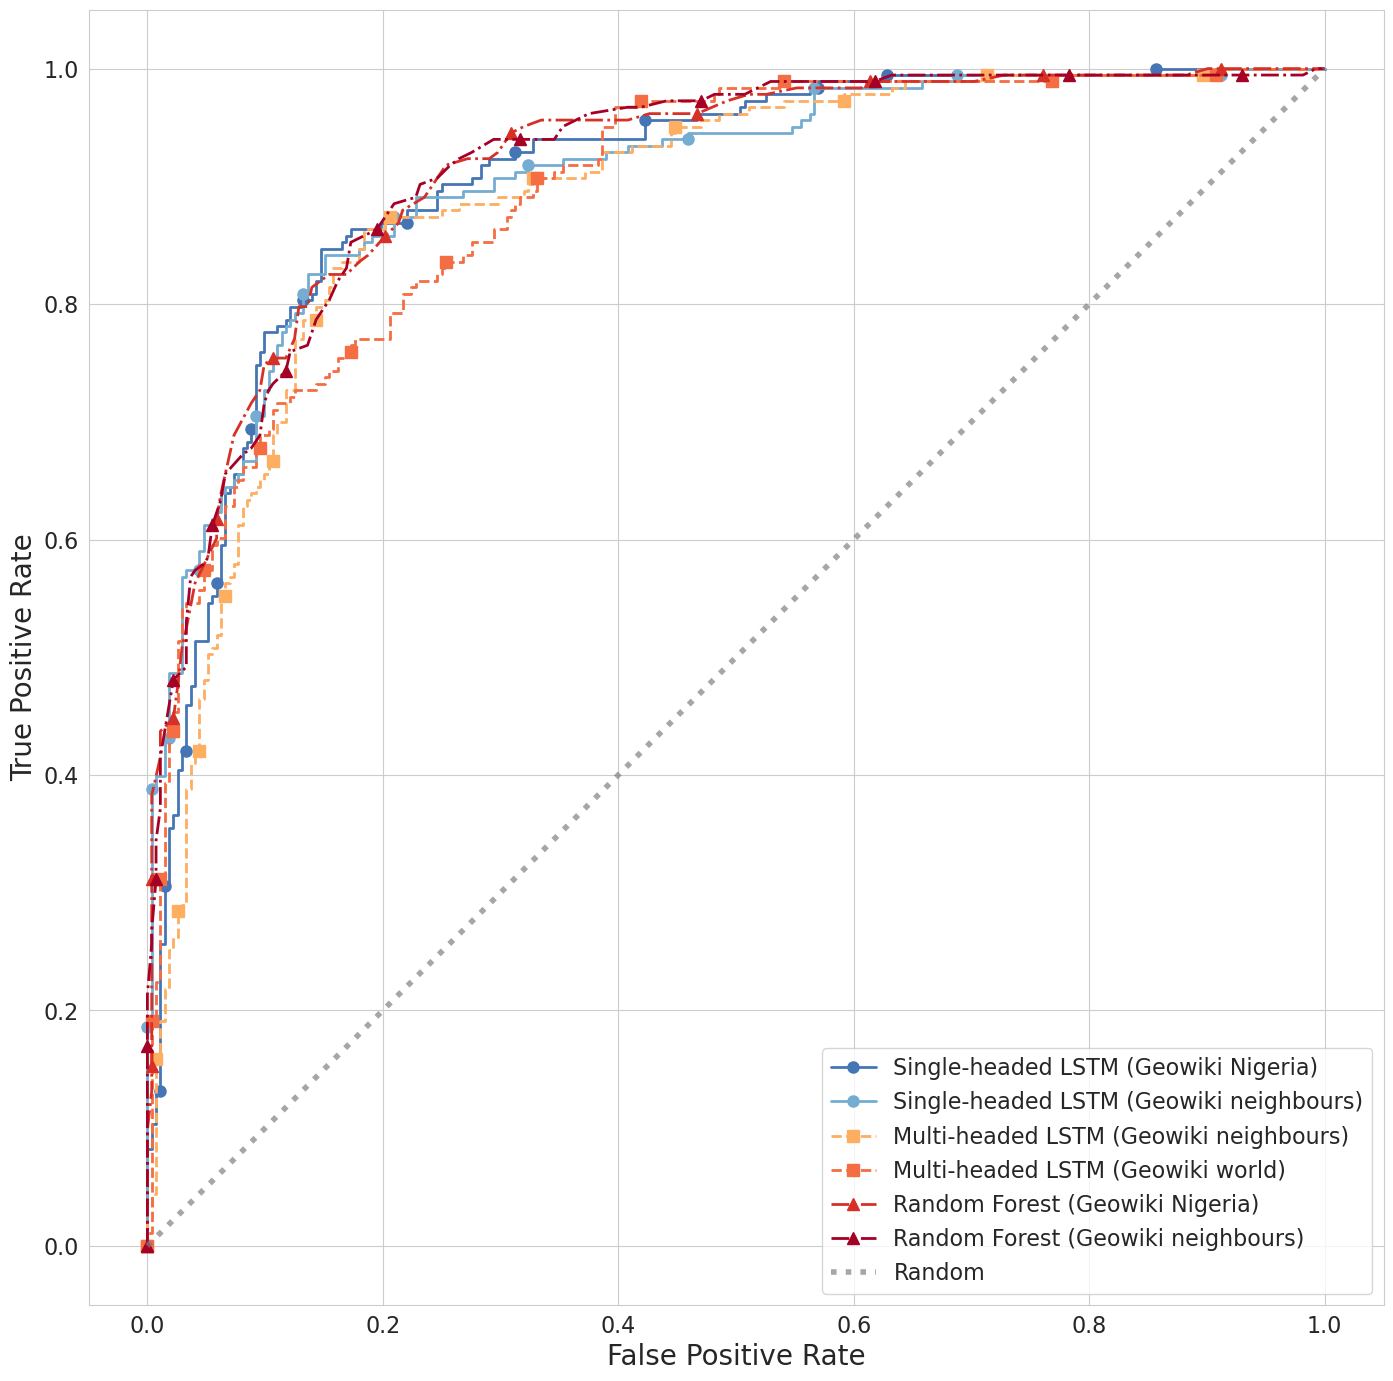

In [ ]:
# Set the style
#sns.set_style("whitegrid")
#sns.set_palette("colorblind")

# Create distinct marker and line style combinations
model_styles = {
    'Single-headed LSTM': {'marker': 'o', 'linestyle': '-', 'markersize': 8},
    'Multi-headed LSTM': {'marker': 's', 'linestyle': '--', 'markersize': 8},
    'Random Forest': {'marker': '^', 'linestyle': '-.', 'markersize': 8}
}

# Get colorblind-friendly palette
#colors = sns.color_palette("colorblind", n_colors=6)

colors = ['#4575b4',  # Blue for Single LSTM 1
          '#74add1',  # Lighter blue for Single LSTM 2
          '#fdae61',  # Orange for Multi LSTM 1
          '#f46d43',  # Darker orange for Multi LSTM 2
          '#d73027',  # Red for RF 1
          '#a50026']  # Dark red for RF 2

fig, ax = plt.subplots(figsize=(14, 14))

# Plot each model's ROC curve
for i, (labels_, preds_, name) in enumerate(zip(labels, preds, names)):
    # Determine style based on model type
    for model_type, style_dict in model_styles.items():
        if model_type in name:
            style = style_dict
            break
    
    fpr, tpr, thresholds = roc_curve(labels_, preds_)
    ax.plot(fpr, tpr, 
            label=name, 
            color=colors[i],
            linestyle=style['linestyle'],
            marker=style['marker'],
            markersize=style['markersize'],
            markevery=0.1,  # Show marker every 10% of the points
            linewidth=2)

# Reference line
ax.plot([0, 1], [0, 1], 
        linestyle=':', 
        label='Random', 
        linewidth=4, 
        color='gray',
        alpha=0.7)

ax.set_xlabel("False Positive Rate", fontsize=20)
ax.set_ylabel("True Positive Rate", fontsize=20)
ax.tick_params(labelsize=16)
ax.minorticks_on()
#ax.tick_params(size=5, which='minor')
ax.legend(loc="lower right", fontsize=16, bbox_to_anchor=(1.0, 0.0))

# Maintain aspect ratio for better visualization of the curve
ax.set_aspect('equal')

# Tight layout to prevent cutting off of labels
plt.tight_layout()

# fig.savefig('../figures/roc-curve-models_latest.png', bbox_inches='tight', dpi=600)
# fig.savefig('../figures/roc-curve-models_latest.pdf', bbox_inches='tight', dpi=600)
plt.show()

Without grid:

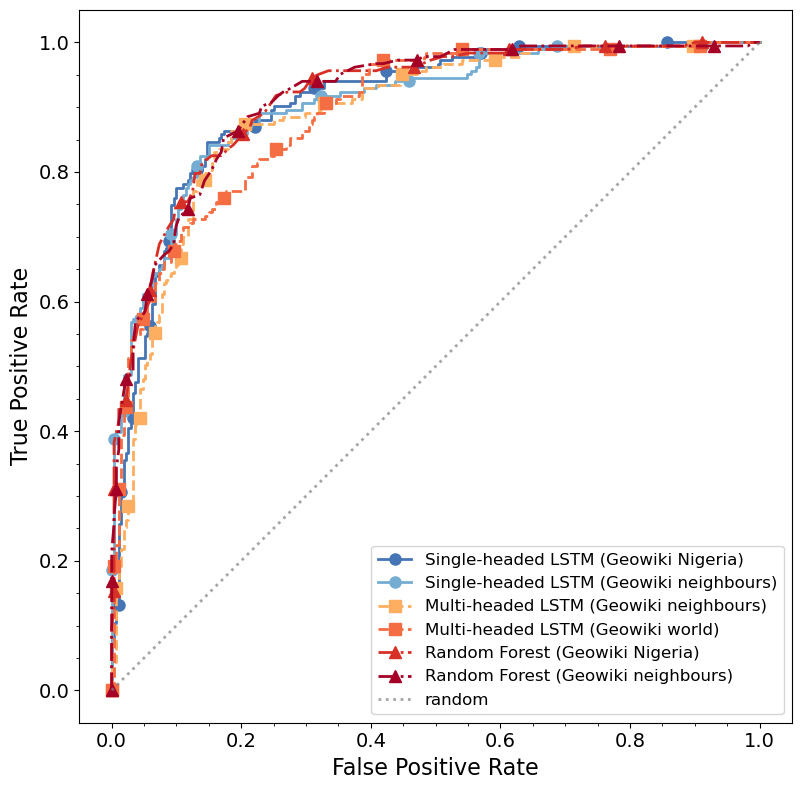

In [ ]:
# Set the style to a clean look
plt.style.use('default')

# Create distinct marker and line style combinations
model_styles = {
    'Single-headed LSTM': {'marker': 'o', 'linestyle': '-', 'markersize': 8},
    'Multi-headed LSTM': {'marker': 's', 'linestyle': '--', 'markersize': 8},
    'Random Forest': {'marker': '^', 'linestyle': '-.', 'markersize': 8}
}

# Custom color palette
colors = ['#4575b4',  # Blue for Single LSTM 1
          '#74add1',  # Lighter blue for Single LSTM 2
          '#fdae61',  # Orange for Multi LSTM 1
          '#f46d43',  # Darker orange for Multi LSTM 2
          '#d73027',  # Red for RF 1
          '#a50026']  # Dark red for RF 2

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each model's ROC curve
for i, (labels_, preds_, name) in enumerate(zip(labels, preds, names)):
    # Determine style based on model type
    for model_type, style_dict in model_styles.items():
        if model_type in name:
            style = style_dict
            break
    
    fpr, tpr, thresholds = roc_curve(labels_, preds_)
    ax.plot(fpr, tpr, 
            label=name, 
            color=colors[i],
            linestyle=style['linestyle'],
            marker=style['marker'],
            markersize=style['markersize'],
            markevery=0.1,  # Show marker every 10% of the points
            linewidth=2)

# Reference line
ax.plot([0, 1], [0, 1], 
        linestyle=':', 
        label='random', 
        linewidth=2, 
        color='gray',
        alpha=0.7)

ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.tick_params(labelsize=14)
ax.minorticks_on()
ax.legend(loc="lower right", fontsize=12, bbox_to_anchor=(1.0, 0.0))

# Maintain aspect ratio for better visualization of the curve
ax.set_aspect('equal')

# Tight layout to prevent cutting off of labels
plt.tight_layout()

fig.savefig('../figures/roc-curve-models_latest.png', bbox_inches='tight', dpi=600)
fig.savefig('../figures/roc-curve-models_latest.pdf', bbox_inches='tight', dpi=600)
plt.show()